# KMeans Clustering

## Imports & Load Data

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv(r"/kaggle/input/sample-sales-data/sales_data_sample.csv", sep=",", encoding='Latin-1')
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%matplotlib inline

sns.set()
sns.set_palette('autumn')
SNS_CMAP = 'autumn'
colors = sns.palettes.color_palette(SNS_CMAP)
pd.options.mode.chained_assignment = None
from typing import List, Tuple

In [5]:
df.head().style.background_gradient(cmap=SNS_CMAP)

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,CUSTOMERNAME,PHONE,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.700000,2,2871.000000,2/24/2003 0:00,Shipped,1,2,2003,Motorcycles,95,S10_1678,Land of Toys Inc.,2125557818,897 Long Airport Avenue,nan,NYC,NY,10022,USA,nan,Yu,Kwai,Small
1,10121,34,81.350000,5,2765.900000,5/7/2003 0:00,Shipped,2,5,2003,Motorcycles,95,S10_1678,Reims Collectables,26.47.1555,59 rue de l'Abbaye,nan,Reims,nan,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.740000,2,3884.340000,7/1/2003 0:00,Shipped,3,7,2003,Motorcycles,95,S10_1678,Lyon Souveniers,+33 1 46 62 7555,27 rue du Colonel Pierre Avia,nan,Paris,nan,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.260000,6,3746.700000,8/25/2003 0:00,Shipped,3,8,2003,Motorcycles,95,S10_1678,Toys4GrownUps.com,6265557265,78934 Hillside Dr.,nan,Pasadena,CA,90003,USA,nan,Young,Julie,Medium
4,10159,49,100.000000,14,5205.270000,10/10/2003 0:00,Shipped,4,10,2003,Motorcycles,95,S10_1678,Corporate Gift Ideas Co.,6505551386,7734 Strong St.,nan,San Francisco,CA,nan,USA,nan,Brown,Julie,Medium


In [6]:
agg_df = df.agg(["nunique", "unique", lambda x:x.isna().sum(), "dtypes"]).T
agg_df['unique'] = agg_df['unique'].apply(lambda x: x if len(x)<10 else x[:10])
agg_df.style.apply(lambda s: [f'background-color: rgba({colors[2][0]*255}, {colors[2][1]*255}, {colors[2][2]*255}, 0.5)' if i % 2 == 0 else f'background-color: rgba({colors[5][0]*255}, {colors[5][1]*255}, {colors[5][2]*255}, 0.5)' for i in range(len(s))])

,nunique,unique,,dtypes
ORDERNUMBER,307,[10107 10121 10134 10145 10159 10168 10180 10188 10201 10211],0,int64
QUANTITYORDERED,58,[30 34 41 45 49 36 29 48 22 37],0,int64
PRICEEACH,1016,[ 95.7 81.35 94.74 83.26 100. 96.66 86.13 98.57 92.83 72.55],0,float64
ORDERLINENUMBER,18,[ 2 5 6 14 1 9 7 13 12 4],0,int64
SALES,2763,[2871. 2765.9 3884.34 3746.7 5205.27 3479.76 2497.77 5512.32 2168.54 4708.44],0,float64
ORDERDATE,252,['2/24/2003 0:00' '5/7/2003 0:00' '7/1/2003 0:00' '8/25/2003 0:00' '10/10/2003 0:00' '10/28/2003 0:00' '11/11/2003 0:00' '11/18/2003 0:00' '12/1/2003 0:00' '1/15/2004 0:00'],0,object
STATUS,6,['Shipped' 'Disputed' 'In Process' 'Cancelled' 'On Hold' 'Resolved'],0,object
QTR_ID,4,[1 2 3 4],0,int64
MONTH_ID,12,[ 2 5 7 8 10 11 12 1 4 6],0,int64
YEAR_ID,3,[2003 2004 2005],0,int64


## Preprocessing

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, StandardScaler, OrdinalEncoder, FunctionTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer

In [15]:
def feat_eng(x:pd.DataFrame)->pd.DataFrame:
    df['DAYOFWEEK'] = pd.to_datetime(df['ORDERDATE']).dt.dayofweek.fillna(-1).astype(int)
    return df

num_cols = ['ORDERNUMBER', 'QUANTITYORDERED', 'PRICEEACH', 'ORDERLINENUMBER', 'SALES',
           'QTR_ID', 'MONTH_ID', 'YEAR_ID', 'DAYOFWEEK']
ord_cols = ['DEALSIZE', 'TERRITORY', 'STATUS']
ohe_cols = ['PRODUCTLINE', 'ADDRESSLINE2']
    
preprocessor = Pipeline(steps=[
    ('feat-eng', FunctionTransformer(feat_eng)),
    ('encoder', ColumnTransformer(transformers=[
        ('ordinal encoder', OrdinalEncoder(), ord_cols),
        ('one hot  encoder', OneHotEncoder(), ohe_cols),
        ('passthrough', 'passthrough', num_cols)
    ])),
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler()),
])

preprocessor.fit(df)

Pipeline(steps=[('feat-eng',
                 FunctionTransformer(func=<function feat_eng at 0x7a77b3456dd0>)),
                ('encoder',
                 ColumnTransformer(transformers=[('ordinal encoder',
                                                  OrdinalEncoder(),
                                                  ['DEALSIZE', 'TERRITORY',
                                                   'STATUS']),
                                                 ('one hot  encoder',
                                                  OneHotEncoder(),
                                                  ['PRODUCTLINE',
                                                   'ADDRESSLINE2']),
                                                 ('passthrough', 'passthrough',
                                                  ['ORDERNUMBER',
                                                   'QUANTITYORDERED',
                                                   'PRICEEACH',
                                                   'ORDERLINENUMBER', 'SALES',
                                                   'QTR_ID', 'MONTH_ID',
                                                   'YEAR_ID', 'DAYOFWEEK'])])),
                ('imputer', SimpleImputer()), ('scaler', StandardScaler())])

In [16]:
X = preprocessor.transform(df)

## K-Means

In [17]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

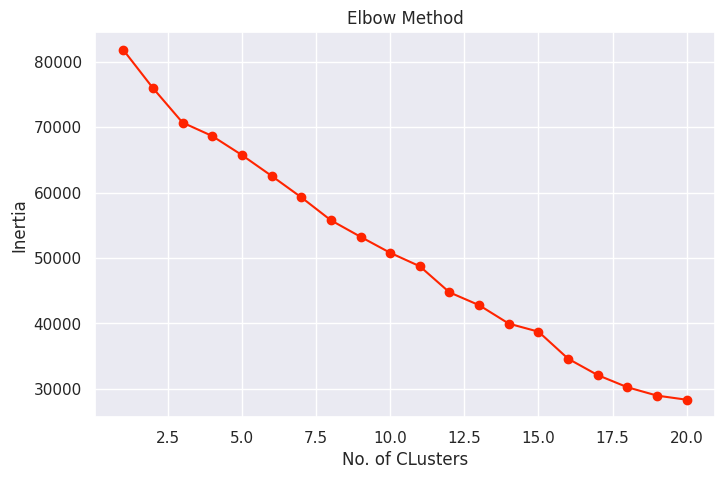

In [22]:
inertia  = []
MAX_CLUSTERS = 20
for i in range(1, MAX_CLUSTERS+1):
    model = KMeans(n_clusters=i)
    model.fit(X)
    inertia.append(model.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Methodk')
plt.xlabel('No. of CLusters')
plt.ylabel('Inertia')
plt.show()

In [27]:
df_2d = pd.DataFrame({'P1': X_pca[:, 0], 'P2': X_pca[:, 1],
                      'T1': X_tsne[:, 0], 'T2': X_tsne[:, 1], 'cluster': Z, 'SALES': df['SALES']})
df_2d['SALES'] = pd.cut(df_2d['SALES'], bins=5)

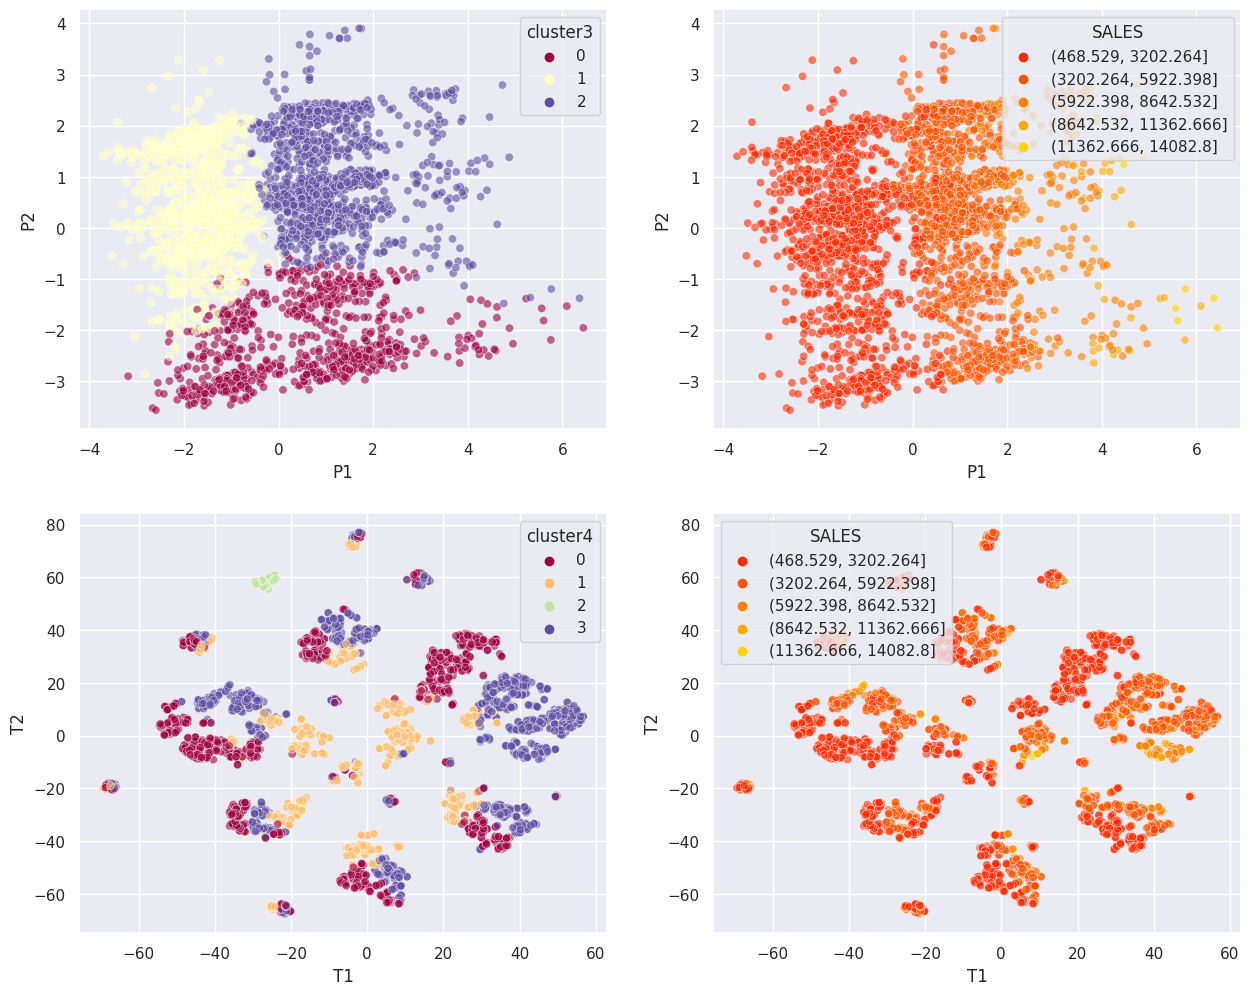

In [31]:
Z3 = KMeans(n_clusters=3).fit_predict(X)
Z4 = KMeans(n_clusters=4).fit_predict(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
df_2d = pd.DataFrame({'P1': X_pca[:, 0], 'P2': X_pca[:, 1],
                      'T1': X_tsne[:, 0], 'T2': X_tsne[:, 1],
                      'cluster3': Z3, 'cluster4': Z4,'SALES': df['SALES']})
df_2d['SALES'] = pd.cut(df_2d['SALES'], bins=5)

fig, ax = plt.subplots(2, 2, figsize=(15, 12))
sns.scatterplot(data=df_2d, x='P1', y='P2', hue='cluster3', palette='Spectral', ax=ax[0][0], alpha=0.6)
sns.scatterplot(data=df_2d, x='P1', y='P2', hue='SALES', palette='autumn', ax=ax[0][1], alpha=0.6)
sns.scatterplot(data=df_2d, x='T1', y='T2', hue='cluster4', palette='Spectral', ax=ax[1][0], alpha=0.6)
sns.scatterplot(data=df_2d, x='T1', y='T2', hue='SALES', palette='autumn', ax=ax[1][1], alpha=0.6)
plt.show()

In [33]:
import plotly.express as px
from sklearn.preprocessing import KBinsDiscretizer

Z = KMeans(n_clusters=3).fit_predict(X)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)
df_3d = pd.DataFrame({'P1': X_pca[:, 0], 'P2': X_pca[:, 1], 'P3': X_pca[:, 2],
                      'cluster': Z, 'SALES': df['SALES']})
kbins = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
df_3d['SALES'] = kbins.fit_transform(df_3d['SALES'].values.reshape(-1, 1)).flatten()

fig = px.scatter_3d(
    df_3d, 
    x='P1', 
    y='P2', 
    z='P3', 
    color='cluster',  
    symbol='SALES',  
    title='3D PCA Scatter Plot with KMeans Clusters and Binned Sales',
    opacity=0.7
)

fig.show()